

# Leaf Segmentation with <img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="200">

Trains a detectron2 model on Superfund leaf dataset.



## Install requirements

In [2]:
# requirements
!pip install pyyaml==5.1
!pip install opencv-python

# cocosplit requirements
!pip install sklearn funcy argparse scikit-multilearn

!pip install matplotlib

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


## Split dataset into test/validation sets

In [3]:
!pwd



run = f"python ./cocosplit.py\
         --having-annotations\
         -s 0.8\
         data/leaves-coco-verified.json\
         output_11-8/leaves_train.json\
         output_11-8/leaves_val.json"

!{run}

/home/jovyan/work
Saved 1083 entries in output_11-8/leaves_train.json and 296 in output_11-8/leaves_val.json


In [4]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

torch:  1.12 ; cuda:  cu116


# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

Register the leaf dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [5]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("train", {}, "/home/jovyan/work/output_11-8/leaves_train.json", "/home/jovyan/work/data/")
register_coco_instances("val", {}, "/home/jovyan/work/output_11-8/leaves_val.json", "/home/jovyan/work/data/")



To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



WARNING [11/08 20:26:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/08 20:26:55 d2.data.datasets.coco]: Loaded 155 images in COCO format from /home/jovyan/work/output_11-8/leaves_train.json
Metadata(name='train', json_file='/home/jovyan/work/output_11-8/leaves_train.json', image_root='/home/jovyan/work/data/', evaluator_type='coco', thing_classes=['leaf', 'qr', 'red-square'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2})


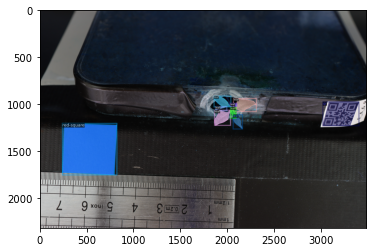

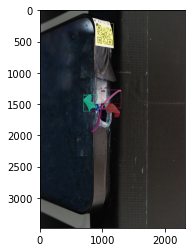

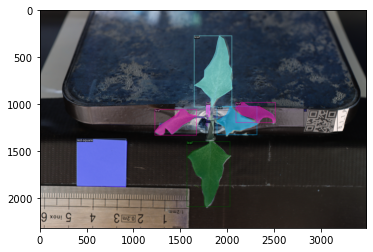

In [6]:
leaf_metadata = MetadataCatalog.get("train")
dataset_dicts = DatasetCatalog.get("train")

print(leaf_metadata)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=leaf_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [7]:
import os

import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.evaluation import CityscapesSemSegEvaluator, DatasetEvaluators, SemSegEvaluator
from detectron2.projects.deeplab import add_deeplab_config, build_lr_scheduler


def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        )
    ]
    if cfg.INPUT.CROP.ENABLED:
        print('CROP ENABLED!!!')
        augs.append(
            T.RandomCrop_CategoryAreaConstraint(
                cfg.INPUT.CROP.TYPE,
                cfg.INPUT.CROP.SIZE,
                cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
                cfg.MODEL.SEM_SEG_HEAD.IGNORE_VALUE,
            )
        )
    else:
        print('CROP NOT ENABLED!!!')
    augs.append(T.RandomFlip())
    return augs


class AugmentedTrainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains a number pre-defined logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can use the cleaner
    "SimpleTrainer", or write your own training loop.
    """

    # @classmethod
    # def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    #     """
    #     Create evaluator(s) for a given dataset.
    #     This uses the special metadata "evaluator_type" associated with each builtin dataset.
    #     For your own dataset, you can simply create an evaluator manually in your
    #     script and do not have to worry about the hacky if-else logic here.
    #     """
    #     if output_folder is None:
    #         output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    #     evaluator_list = []
    #     evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    #     if evaluator_type == "sem_seg":
    #         return SemSegEvaluator(
    #             dataset_name,
    #             distributed=True,
    #             output_dir=output_folder,
    #         )
    #     if evaluator_type == "cityscapes_sem_seg":
    #         return CityscapesSemSegEvaluator(dataset_name)
    #     if len(evaluator_list) == 0:
    #         raise NotImplementedError(
    #             "no Evaluator for the dataset {} with the type {}".format(
    #                 dataset_name, evaluator_type
    #             )
    #         )
    #     if len(evaluator_list) == 1:
    #         return evaluator_list[0]
    #     return DatasetEvaluators(evaluator_list)

    @classmethod
    def build_train_loader(cls, cfg):
        
        print('**********custom build train loader!!!!!!!!')
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))

        return build_detection_train_loader(cfg, mapper=mapper)

    # @classmethod
    # def build_lr_scheduler(cls, cfg, optimizer):
    #     """
    #     It now calls :func:`detectron2.solver.build_lr_scheduler`.
    #     Overwrite it if you'd like a different scheduler.
    #     """
    #     return build_lr_scheduler(cfg, optimizer)



In [9]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.OUTPUT_DIR = './output_11-8'
# cfg.INPUT.CROP.ENABLED = True
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = AugmentedTrainer(cfg) 


[11/08 20:27:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [10]:
trainer.resume_or_load(resume=False)
trainer.train()

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[11/08 20:28:12 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/08 20:28:39 d2.utils.events]:  eta: 1:46:09  iter: 19  total_loss: 3.449  loss_cls: 1.528  loss_box_reg: 0.1941  loss_mask: 0.6896  loss_rpn_cls: 0.92  loss_rpn_loc: 0.1006  time: 1.2944  data_time: 1.0716  lr: 4.9953e-06  max_mem: 2559M
[11/08 20:29:05 d2.utils.events]:  eta: 1:45:04  iter: 39  total_loss: 3.075  loss_cls: 1.387  loss_box_reg: 0.2634  loss_mask: 0.6867  loss_rpn_cls: 0.6794  loss_rpn_loc: 0.1263  time: 1.2862  data_time: 1.0839  lr: 9.9902e-06  max_mem: 2559M
[11/08 20:29:29 d2.utils.events]:  eta: 1:44:12  iter: 59  total_loss: 2.759  loss_cls: 1.103  loss_box_reg: 0.3237  loss_mask: 0.6786  loss_rpn_cls: 0.5345  loss_rpn_loc: 0.1292  time: 1.2647  data_time: 1.0285  lr: 1.4985e-05  max_mem: 2559M
[11/08 20:29:55 d2.utils.events]:  eta: 1:43:47  iter: 79  total_loss: 2.404  loss_cls: 0.8644  loss_box_reg: 0.3737  loss_mask: 0.6681  loss_rpn_cls: 0.3061  loss_rpn_loc: 0.1508  time: 1.2665  data_time: 1.0815  lr: 1.998e-05  max_mem: 2614M
[11/08 20:30:22 d2.utils.e

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("val")
leaf_metadata = MetadataCatalog.get("val")

for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=leaf_metadata, 
                   # scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, RotatedCOCOEvaluator
from detectron2.data import build_detection_test_loader

evaluator = RotatedCOCOEvaluator("val", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
cocoGt = COCO(MetadataCatalog.get("val").json_file)
print(cocoGt)
cocoDt = cocoGt.loadRes("./output/coco_instances_results.json")
cocoEval = COCOeval(cocoGt,cocoDt,"segm")
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()